## Initial Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project')

In [4]:
import pandas as pd
import numpy as np
from data_preprocessing import DataReader, DataBalancer, DataPreparer
from model import ModelBuilder
import keras
from keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet201
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ReduceLROnPlateau
from sklearn.utils import resample
import sklearn.metrics as m
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

In [5]:
BALANCE_COUNT_PER_CLASS = 1200
AUGMENTATION_ROTATION = 0.2
BATCH_SIZE = 8
CHANNELS = 3
IMAGE_RESIZE = [224, 224]
CLASSES = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

## Data Pre-Processing

In [6]:
dr = DataReader()
db = DataBalancer(BALANCE_COUNT_PER_CLASS, CLASSES)
dp = DataPreparer(AUGMENTATION_ROTATION, BATCH_SIZE, CHANNELS, IMAGE_RESIZE, CLASSES)

In [7]:
df_train = dr.capture_df('train')
df_validate = dr.capture_df('validate')
df_test = dr.capture_df('test')

In [8]:
df_train.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,img_path
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...


In [9]:
df_train = db.balance_data(df_train)
len(df_train)

8400

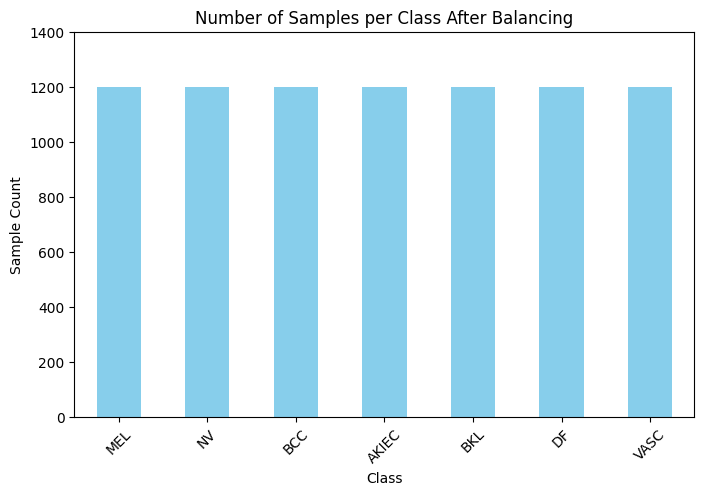

In [10]:
class_counts = df_train[CLASSES].sum()

# Plot bar chart
plt.figure(figsize=(8,5))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Samples per Class After Balancing')
plt.ylabel('Sample Count')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.ylim(0, max(class_counts) + 200)
plt.show()

In [11]:
df_train = dp.create_dataset(df_train, True)
df_validate = dp.create_dataset(df_validate, False)
df_test = dp.create_dataset(df_test, False)

## Model

### Model Building and Training


In [12]:
# Fully-connected layer hyperparameters
DENSE_LAYER1 = 1536
DROPOUT1 = 0.5
DENSE_LAYER2 = 640
DROPOUT2 = 0.2

In [13]:
mb = ModelBuilder(CHANNELS, IMAGE_RESIZE)

In [14]:
model = mb.build_model(DENSE_LAYER1, DROPOUT1, DENSE_LAYER2, DROPOUT2)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
total_params = model.count_params()
print(f"Total Parameters: {total_params:,}")

model.summary()

Total Parameters: 22,269,511


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 22,269,511 (84.95 MB)

 Trainable params: 22,036,103 (84.06 MB)

 Non-trainable params: 233,408 (911.75 KB)

In [16]:
model.compile(
    optimizer=Adam(learning_rate=3.54e-05),
    loss='categorical_crossentropy',
     metrics=['accuracy']
    )

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
start_time = time.time()
hist = model.fit(df_train,epochs=30,validation_data=df_validate,callbacks=[learning_rate_reduction])
end_time = time.time()
duration = end_time - start_time
print(f"Model DenseNet201 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 1097s 529ms/step - accuracy: 0.3870 - loss: 1.8889 - val_accuracy: 0.6839 - val_loss: 1.0546 - learning_rate: 3.5400e-05
Epoch 2/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 88s 82ms/step - accuracy: 0.6504 - loss: 1.0577 - val_accuracy: 0.7824 - val_loss: 0.8804 - learning_rate: 3.5400e-05
Epoch 3/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 89s 82ms/step - accuracy: 0.7220 - loss: 0.8338 - val_accuracy: 0.7358 - val_loss: 0.9993 - learning_rate: 3.5400e-05
Epoch 4/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 88s 82ms/step - accuracy: 0.7584 - loss: 0.7315 - val_accuracy: 0.7565 - val_loss: 0.8873 - learning_rate: 3.5400e-05
Epoch 5/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7986 - loss: 0.5986
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.7700000171316788e-05.
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 89s 82ms/step - accuracy: 0.7986 - loss: 0.5986 - val_accuracy: 0.7513 - val_loss: 0.9733 - learning_rate: 3.5400e-05
Epoch 6/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
model_save_name = 'modelDN201.keras'
path = f"/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/saved_models/{model_save_name}"
model.save(path)